# Snow removal, complaints and Monte Carlo Markov Chains

My brother lives with his girlfriend in Saint-Henry, a neighborhood in Montreal.  One day they were talking to me about how aweful the community's new snow removal services were. Dents on cars, destroyed lawns and snow that just wasn't removed. The community was in an uproar and apperently due to the volume of complaints, the local goverment ended up firing the company in charge. 

So I thought this would be a great real life case to do some A/B testing with Monte Carlo Markov chains! 

# About the data

I'll be using the same montreal 311 data set I had used earlier in a recent hackathon (view earlier post) to look at the number of complaints or "requests" pertaining to snow removal. 

You can get the data for yourself here: http://donnees.ville.montreal.qc.ca/dataset/requete-311

First we'll look at the data, see what we can infer right away, then I will introduce you to Monte Carolo Markov Chains and see what they can do for us. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import numpy as np
import matplotlib


In [2]:
try:
    snow_df=pd.read_csv("../311snow.csv",index_col="DDS_DATE_CREATION",parse_dates=True,encoding = "ISO-8859-1")
    print("used smaller csv")
except:
    data=pd.read_csv("../311data.csv",index_col="DDS_DATE_CREATION",parse_dates=True)
    print("used LARGER csv")
    snow_df=data[data.ACTI_NOM.str.contains("Neige")]
    #print(data.columns)
    #snow_df.sort_index(inplace=True);
    #saving smaller df for future reference
    snow_df.to_csv("../311snow.csv")

used smaller csv


# Quick word about the data

The data is has 4 general types or "Nature" in French. There's complaints, requests, commentaries and some other thing. Now when you look online a request for something dealing with trash could be that the city didn't pick up the trash at a given spot. You'd think that would be a complaint but it's actually called a request. All in all there are very few data points classified as complaints and since the difference seems tenuous I decided to just merge them all. Anybody calling the city to make a request or complaint or a "comment" on anything dealing with snow, that'll be considered a complaint in my analysis. 



In [3]:
snow_df.columns

Index(['ID_UNIQUE', 'NATURE', 'ACTI_NOM', 'TYPE_LIEU_INTERV', 'RUE',
       'RUE_INTERSECTION1', 'RUE_INTERSECTION2', 'LOC_ERREUR_GDT',
       'ARRONDISSEMENT', 'ARRONDISSEMENT_GEO', 'LIN_CODE_POSTAL',
       'PROVENANCE_ORIGINALE', 'PROVENANCE_TELEPHONE', 'PROVENANCE_COURRIEL',
       'PROVENANCE_PERSONNE', 'PROVENANCE_COURRIER', 'PROVENANCE_TELECOPIEUR',
       'PROVENANCE_INSTANCE', 'PROVENANCE_MOBILE', 'PROVENANCE_MEDIASOCIAUX',
       'PROVENANCE_SITEINTERNET', 'UNITE_RESP_PARENT', 'LOC_LONG', 'LOC_LAT',
       'LOC_X', 'LOC_Y'],
      dtype='object')

In [4]:
snow_df=snow_df[snow_df.ARRONDISSEMENT=="Le Sud-Ouest"]

In [5]:
snow_df=snow_df[["NATURE","ACTI_NOM"]]

In [6]:
snow_df["Everything snow related"]=1
snow_df.sort_index(inplace=True)

In [7]:
NATURE_dummied=pd.get_dummies(snow_df.NATURE)

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)
snow_df=pd.concat([snow_df,NATURE_dummied],axis=1)
snow_df=snow_df.resample("D").sum()
snow_df=snow_df.fillna(0)


#  The weather data

I'm bringing in the weather data so see how complaints related to the amount of snow that was actually on the ground.

In [9]:
weather_data=pd.read_csv("../weatherdata.csv",index_col="Datettime",parse_dates=True)
weather_data = weather_data.drop(['Max Temp Flag',"Unnamed: 10","Unnamed: 11"], 1)
weather_data=weather_data.fillna(0)

Here's what it looks like

In [10]:
weather_data.head()

,Max_Temp,Min_Temp,Mean_Temp,Total_Rain_mm,Total_Snow_cm,Total_Precip_mm,Snow_on_Grnd_cm,Dir_of_Max_Gust
Datettime,,,,,,,,
2014-01-01,-16.5,-24.6,-20.6,0.0,0.0,0.0,23.0,29.0
2014-01-02,-22.6,-27.3,-25.0,0.0,1.4,1.4,23.0,2.0
2014-01-03,-19.2,-24.3,-21.8,0.0,0.0,0.0,21.0,3.0
2014-01-04,-8.6,-23.3,-16.0,0.0,0.0,0.0,20.0,0.0
2014-01-05,0.3,-12.6,-6.2,12.2,1.8,14.0,19.0,7.0


In [11]:
weather_data=weather_data[["Snow_on_Grnd_cm","Total_Snow_cm"]]
snow_df=pd.merge(snow_df, weather_data, left_on=[snow_df.index.date],right_on=[weather_data.index.date])
snow_df.set_index(pd.DatetimeIndex(snow_df['key_0']),inplace=True)
snow_df=snow_df.drop("key_0",1)
snow_df=snow_df.resample("D").sum()
snow_df.dropna(inplace=True)

# Complaints across time

(You can change the start date below if you want to zoom in closer to the present)

[]

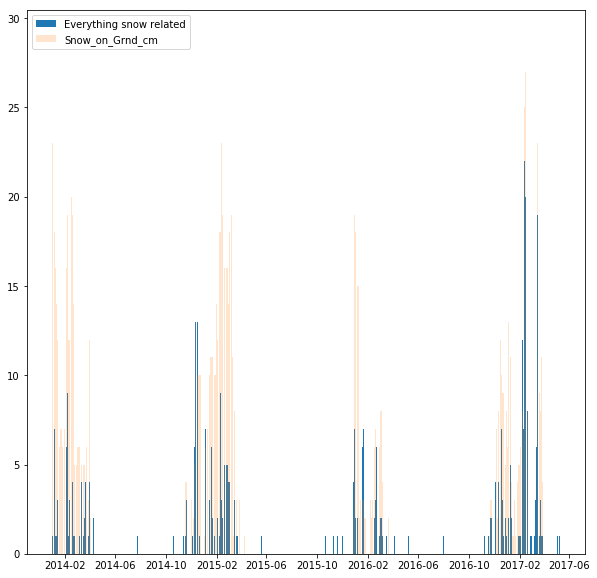

In [12]:
import datetime

#as_of=datetime.date(2016, 9, 1)
as_of=datetime.date(2014, 1, 1)

plt.bar(snow_df[as_of:].index, snow_df[as_of:]["Everything snow related"],label="Everything snow related")
plt.bar(snow_df[as_of:].index, snow_df[as_of:]["Snow_on_Grnd_cm"],label="Snow_on_Grnd_cm",alpha=0.2)
plt.legend()
plt.plot()
#snow_df[["Everything snow related","Snow_on_Grnd_cm"]].plot()

# Zooming in...
Seeing as we only want to deal with the winter months, we'll keep the months where there was actually some snow and get rid of the rest. 


# Snow on the ground

The weather dataset has two columns dealing with snow. One is Snow_on_Grnd_cm and the other which is a lot more sparse is called Total_Snow_cm. I'm assuming Total_Snow_cm must represent the snowfall or something because the values there tend to be a lot lower and definitely don't include Snow_on_Grnd_cm. 

In [13]:
snow_df["some_snow"]=snow_df.Snow_on_Grnd_cm+snow_df.Total_Snow_cm
snow_df.some_snow=snow_df.some_snow.apply(lambda x: x>0)
snow_df=snow_df[snow_df.some_snow==True]
snow_df=snow_df.drop("some_snow",1)

# Dividing up the winters...

In [14]:

def group_by_season(df):
    list_of_season=[]
        
    years=pd.Series(df.index.year)
    months=pd.Series(df.index.month)
    
    month_differences=(years-years.shift())*12+(months-months.shift())
    
    season_df=pd.Series(month_differences>1)
    
    indexes=season_df[season_df==True].index
    
    latest_index=0
    for each_index in indexes:
        #print(each_index)
        list_of_season.append(df.iloc[latest_index:each_index,:])
        #print("----")
        #print(df.iloc[latest_index,:].index)
        #print(df.iloc[each_index,:].index)
        latest_index=each_index
    
    #last part
    list_of_season.append(df.iloc[indexes[-1]:,:])
    
    return list_of_season


list_of_dfs=group_by_season(snow_df)




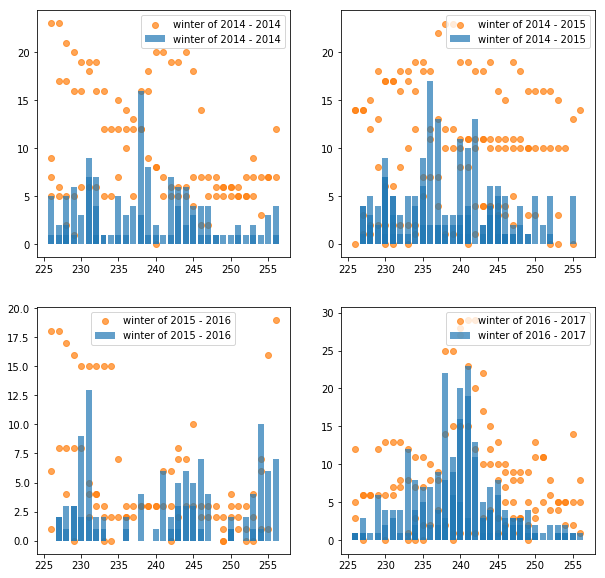

In [15]:
plt.title("Looking at the past few winters")

plt.subplot(221)

for i,each_winter in enumerate(list_of_dfs):
    plot_location=221+i
    plt.subplot(plot_location)
    min_year=each_winter.index.year.min()
    max_year=each_winter.index.year.max()
    idx=[]
    for each in each_winter.index.day:
        if each<140: #Jan winter part
            each+=365
        each-=140
        idx.append(each)    
    #["Everything snow related"]
    

    plt.bar(idx, each_winter["Everything snow related"],alpha=0.7,label="Complaints of winter of %i - %i"%(min_year,max_year))
    plt.scatter(idx, each_winter["Snow_on_Grnd_cm"],alpha=0.7,label="Snow levels of %i - %i"%(min_year,max_year))
    plt.xlim()
    plt.legend()
    #each_winter.plot()

# Here I tried to use plotly, but getting it to animate the simplest of things is near impossible. Gave up. Might try tableau for next post.


import plotly
import plotly.plotly as py
from plotly.grid_objs import Grid, Column

import time


animation_columns=[]

for i,each_winter in enumerate(list_of_dfs):

    min_year=each_winter.index.year.min()
    max_year=each_winter.index.year.max()
    idx=[]
    
    for each in each_winter.index.day:
        if each<140: #Jan winter part
            each+=365
        each-=140
        idx.append(each)    
    #["Everything snow related"]

    animation_columns.append(Column(idx, 'x%i'%i))
    animation_columns.append(Column(each_winter["Everything snow related"], 'y%i'%i))
    animation_columns.append(Column(each_winter["Snow_on_Grnd_cm"], 'snow_y%i'%i))

grid = Grid(animation_columns)

py.grid_ops.upload(grid, 'Saint_Henry_winter'+str(time.time()), auto_open=False)

# create figure
figure = {
    'data': [

        {
            'xsrc': grid.get_column_reference('x0'),
            'ysrc': grid.get_column_reference('y0'),
            'mode': 'markers',
            'marker': {'color': 'yellow', 'size': 10},
            "type": 'bar',
            "name":"complaints for winter 2013-2014"
        }
        ,
        {
            'xsrc': grid.get_column_reference('x0'),
            'ysrc': grid.get_column_reference('snow_y0'),
            'mode': 'markers',
            'marker': {'color': 'blue', 'size': 10},
            "type": 'scatter',
            "name":"snow levels winter 2013-2014"
        }
    ],
    
    'layout': {'title': 'Winters in county "Le Sud Ouest"',
               'xaxis': {'range': [0, 2], 'autorange': True},
               'yaxis': {'range': [0, 2], 'autorange': True},
               'updatemenus': [{
                   'buttons': [
                       {'args': [],
                        'label': 'Play',
                        'method': 'animate'
                       }
                       
               ],
               'pad': {'r': 10, 't': 87},
               'showactive': False,
               'type': 'buttons'
                }]},
    'frames': [
        {
            'data': [
                {
                    'xsrc': grid.get_column_reference('x0'),
                    'ysrc': grid.get_column_reference('y0'),
                    'mode': 'markers',
                    'marker': {'color': 'yellow', 'size': 10},
                    "type": 'bar',
                    "name":"complaints for winter 2013-2014"
                }
                ,
                {
                    'xsrc': grid.get_column_reference('x0'),
                    'ysrc': grid.get_column_reference('snow_y0'),
                    'mode': 'markers',
                    "type": 'scatter',
                    'marker': {'color': 'blue', 'size': 10},
                    "name":"snow levels winter 2013-2014"
                }

            ],
            'data': [
                {
                    'xsrc': grid.get_column_reference('x1'),
                    'ysrc': grid.get_column_reference('y1'),
                    'mode': 'markers',
                    'marker': {'color': 'yellow', 'size': 10},
                    "type": 'bar',
                    "name":"complaints for winter 2014-2015"
                }
                ,
                {
                    'xsrc': grid.get_column_reference('x1'),
                    'ysrc': grid.get_column_reference('snow_y1'),
                    'mode': 'markers',
                    "type": 'scatter',
                    'marker': {'color': 'blue', 'size': 10},
                    "name":"snow levels winter 2014-2015"
                }

            ],
        },
        {
            'data': [
                {
                    'xsrc': grid.get_column_reference('x2'),
                    'ysrc': grid.get_column_reference('y2'),
                    'mode': 'markers',
                    'marker': {'color': 'yellow', 'size': 10},
                    "type": 'bar',
                    "name":"complaints for winter 2015-2016"
                }
                ,
                {
                    'xsrc': grid.get_column_reference('x2'),
                    'ysrc': grid.get_column_reference('snow_y2'),
                    'mode': 'markers',
                    'marker': {'color': 'blue', 'size': 10},
                    "type": 'scatter',
                    "name":"snow levels winter 2015-2016"
                }
            ]
        },
        {
            'data': [
                {
                    'xsrc': grid.get_column_reference('x3'),
                    'ysrc': grid.get_column_reference('y3'),
                    'mode': 'markers',
                    'marker': {'color': 'yellow', 'size': 10},
                    "type": 'bar',
                    "name":"complaints for winter 2016-2017"
                }
                ,
                {
                    'xsrc': grid.get_column_reference('x3'),
                    'ysrc': grid.get_column_reference('snow_y3'),
                    'mode': 'markers',
                    'marker': {'color': 'blue', 'size': 10},
                    "type": 'scatter',
                    "name":"snow levels winter 2016-2017"
                }
            ]
        },
    ]
}


py.icreate_animations(figure, 'Saint_Henry_winter'+str(time.time()))

# Combining the winter data points into one continuous series

In [16]:
#list_of_dfs
combining_all_years=pd.DataFrame()
each_winter_idx=[]
for each_winter in list_of_dfs:
    each_winter=each_winter.reset_index()
    if combining_all_years.shape[0]==0:
        combining_all_years=each_winter
    else:
        combining_all_years=pd.concat([combining_all_years,each_winter])
    each_winter_idx.append(combining_all_years.shape[0])


combining_all_years.reset_index(inplace=True)

type_of_snow_data="Snow_on_Grnd_cm" #Snow_on_Grnd_cm Total_Snow_cm

combining_all_years[type_of_snow_data].replace(0,combining_all_years[type_of_snow_data].mean(),inplace=True)
    
combining_all_years=combining_all_years.drop("index",1)




# Normalizing the snow values

One theory could be that there are more complaints when there's more snow. So having more complaints one year could have more to do with the weather than the actual performance of the snow plow company. 

However I didn't feel small changes in snow levels should affect the number resutls that much.

For example if I had divided the complaints by the raw data, 1 complaint / 1 cm = 4 complaints / 4 cm. 

But clearly just because you have 3 more centimeters of snow shouldn't mean you can have 4X times the complaints.

Therefore we'll log the values.

(array([ 0.07848325,  0.07142857,  0.06790123,  0.05202822,  0.01587302,
         0.03262787,  0.02645503,  0.00705467,  0.00176367,  0.00352734]),
 array([  1. ,   3.8,   6.6,   9.4,  12.2,  15. ,  17.8,  20.6,  23.4,
         26.2,  29. ]),
 <a list of 10 Patch objects>)

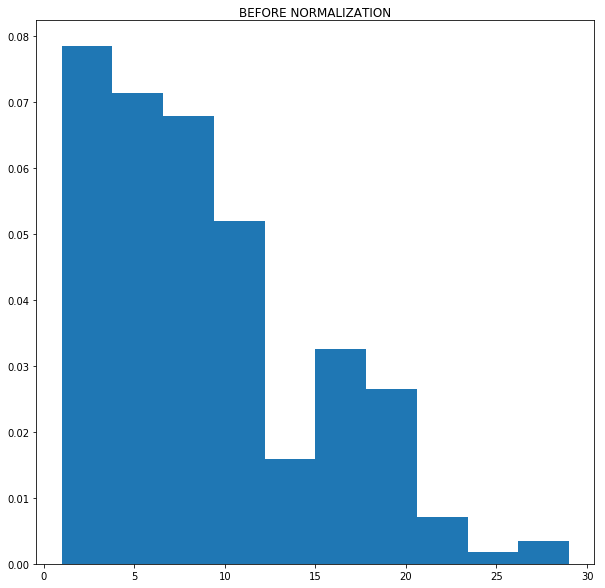

In [17]:
# BEFORE
plt.title("BEFORE NORMALIZATION")
plt.hist(combining_all_years[type_of_snow_data],normed=True)


In [18]:
#normalizing the snow data
combining_all_years[type_of_snow_data]=np.log1p(combining_all_years[type_of_snow_data])+1
#I put in the plus 1 here because I want a minimum of 1. I'll be dividing the complaints by the snow later.

(array([ 0.19147301,  0.30088616,  0.31912168,  0.18235525,  0.5561835 ,
         0.7020677 ,  0.53794798,  0.41941707,  0.36471049,  0.11853091]),
 array([ 1.69314718,  1.9639522 ,  2.23475722,  2.50556224,  2.77636726,
         3.04717228,  3.3179773 ,  3.58878232,  3.85958734,  4.13039236,
         4.40119738]),
 <a list of 10 Patch objects>)

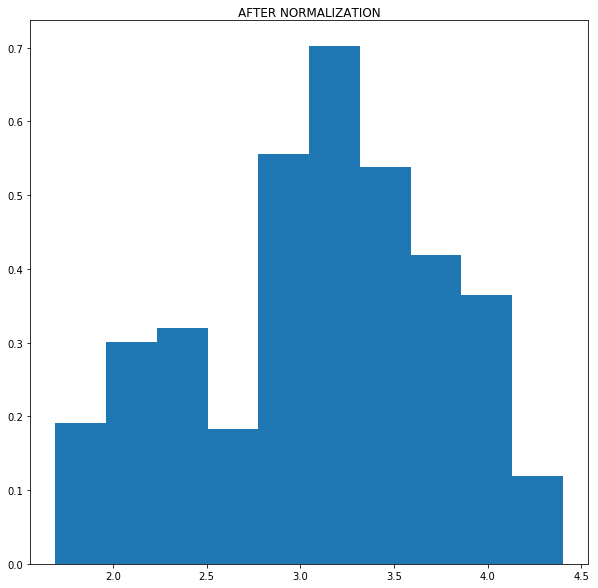

In [19]:
#After
plt.title("AFTER NORMALIZATION")
plt.hist(combining_all_years[type_of_snow_data],normed=True)

# Defining some measurements

In [20]:
combining_all_years["everything_per_snow_cm"]=combining_all_years["Everything snow related"]/combining_all_years[type_of_snow_data]
combining_all_years["complaints_per_snow_cm"]=combining_all_years["Plainte"]/combining_all_years[type_of_snow_data]
combining_all_years["comments_per_snow_cm"]=combining_all_years["Commentaire"]/combining_all_years[type_of_snow_data]
combining_all_years["requests_per_snow_cm"]=combining_all_years["Commentaire"]/combining_all_years[type_of_snow_data]

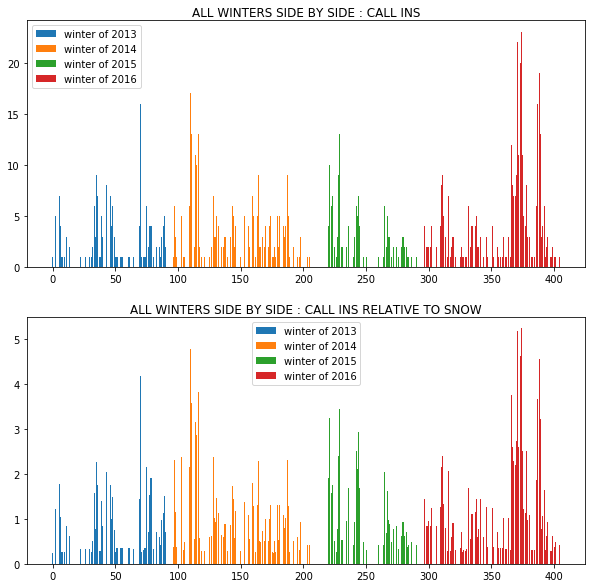

In [21]:

winters=[2013,2014,2015,2016]

old_index=0
plt.subplot(211)
for i,each_idx in enumerate(each_winter_idx):
    
    plt.bar(combining_all_years[old_index:each_idx].index, combining_all_years[old_index:each_idx]["Everything snow related"],label="winter of %i"%winters[i])
    old_index=each_idx
plt.title("ALL WINTERS SIDE BY SIDE : CALL INS")
plt.legend()

old_index=0
plt.subplot(212)
for i,each_idx in enumerate(each_winter_idx):
    plt.bar(combining_all_years[old_index:each_idx].index, combining_all_years[old_index:each_idx]["everything_per_snow_cm"],label="winter of %i"%winters[i])
    old_index=each_idx
plt.title("ALL WINTERS SIDE BY SIDE : CALL INS RELATIVE TO SNOW")
plt.legend()


#plt.scatter(combining_all_years.index, combining_all_years["Snow_on_Grnd_cm"],label="amount of snow in cm")

# Quick note on the above charts

So here we can clearly see that the most recent winter seems to have the largest number of complaints. 

However when you put it in term of complaints relative to the amount of snow, the most recent year doesn't appear to be as bad as you'd think. The winter of 2014 looks similar to the most recent one.

Just out of curiosity let's see what at just the data points that were actually classified as "complaints".

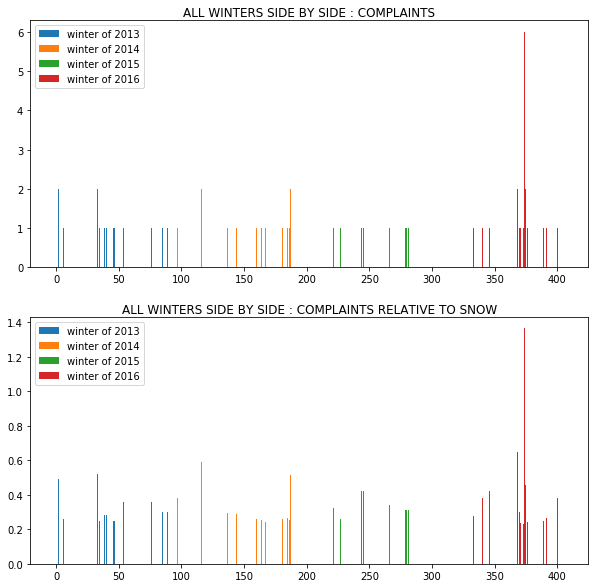

In [22]:
old_index=0
plt.subplot(211)
for i,each_idx in enumerate(each_winter_idx):
    plt.bar(combining_all_years[old_index:each_idx].index, combining_all_years[old_index:each_idx]["Plainte"],label="winter of %i"%winters[i])
    old_index=each_idx
plt.title("ALL WINTERS SIDE BY SIDE : COMPLAINTS")
plt.legend()

old_index=0
plt.subplot(212)
for i,each_idx in enumerate(each_winter_idx):
    plt.bar(combining_all_years[old_index:each_idx].index, combining_all_years[old_index:each_idx]["complaints_per_snow_cm"],label="winter of %i"%winters[i])
    old_index=each_idx
plt.title("ALL WINTERS SIDE BY SIDE : COMPLAINTS RELATIVE TO SNOW")
plt.legend()


Now just looking at what was categorized as complaints, we can clearly see something went wrong during the last winter with or without the snow taken into consideration. Still one could argue that maybe by pure chance more data points were classified as complaints when in fact they could've just been categorized as "comments" or "requests". 

So we'll revert back to the catch all combination of all categories and proceed from there.



# Monte Carlo Markov Chains (the basic components)

# What is it used for?

They're used for finding the best distribution that explains the data. It's parameter tuning.

# What's Monte Carlo?

It's a fancy name that means approximate an integral by a sum of samples that you've simulated. Sometime you'll get these complicated scenarios where solving it analytically can be extremely tedious if not impossible. It's in these cases that you simply run the simulation a bunch of times and take note of the results. After letting your results pile up for a while, you can then get a better sense of the distribution. 

# What's a Markov Chain?

Markov chains is basically the technique by which you will do your sampling. I will not talk about this in-depth here but to be brief it involves transition matrices and matrix of "states". 

Let's say your activities invovle eating and sleeping. When you're eating, the next activity you could be more eating or switching to sleeping. The odds of going from eating to eating again or to sleeping are captured in a vector. Same for the other way around if you were sleeping what are the odds of you continuing to sleep or transitioning to eating, that is also a vector. Combine both of these vectors and you've got a matrix. Your state






In [23]:

sleeping=np.array([0.3,0.7])
eating=np.array([0.1,0.9])
transition_matrix=np.stack([sleeping,eating])
initial_state=np.array([1,0])
print('TRANSITION MATRIX')
print(transition_matrix)


TRANSITION MATRIX
[[ 0.3  0.7]
 [ 0.1  0.9]]



Take a look at the transition matrix, the first row is for when you're transitioning from the state of sleeping. The second row is for when you are transitioning from the state of eating. So to read the first row is to say, starting in the state of sleeping, there is a 0.3 chance of transitioning to the state of sleeping and a 0.7 chance of transitioning to the state to eating. 

Below you will see the state vector which is how we represent wether we are eating or sleeping and finally we'll see what it looks like after we taken a few iterations.

Eventually, after many iterations, the states converge to a stationary distribution of sorts. This is a kind of "learning" that takes place. 



In [24]:
print("INITIAL STATE MATRIX")
print(initial_state)

print("Probabilities of being in each state after 1 turn")
print(np.dot(np.linalg.matrix_power(transition_matrix,1).T,initial_state))

print("Probabilities of being in each state after 2 turns")
print(np.dot(np.linalg.matrix_power(transition_matrix,2).T,initial_state))

print("Probabilities of being in each state after 100 turns")
print(np.dot(np.linalg.matrix_power(transition_matrix,100).T,initial_state))

print("Probabilities of being in each state after 1000 turns")
print(np.dot(np.linalg.matrix_power(transition_matrix,1000).T,initial_state))

INITIAL STATE MATRIX
[1 0]
Probabilities of being in each state after 1 turn
[ 0.3  0.7]
Probabilities of being in each state after 2 turns
[ 0.16  0.84]
Probabilities of being in each state after 100 turns
[ 0.125  0.875]
Probabilities of being in each state after 1000 turns
[ 0.125  0.875]


When we'll be running the MCMC, it's the optimal parameters in the distribution that will be converging.


# MCMC (how it all fits together)

Let's say you think your data looks like it follows a normal distribution, the parameters you are looking for are the mean and the variance. When do you MCMC, you are hill climbing(optimizing) with all the variables to find the ones that are most likely.

MCMC works by doing simulations, lots of and lots of simulation usually in the thousands. At every simulation, the goal is to produce some parameters for you to try and check how good they are at explaining your data.
Every step in your optimization generates a datapoint which is your sample.  By data point we mean a trace of your changing parameter values. So if I tried a mean of 5 for one simulation and then a mean of 6, that's two datapoints in my trace for the mean. 


When doing your steps, there are multiple algos for this, but basically MOST OF THE TIME if your next proposed values don't provide a better answer than the one you currently have, then you remain where you are and create another datapoint with your current values. There is however always a small chance that you will accept the parameter move even if it's a worse answer (this is just so as to be able to explore the whole parameter space). Over time,your parameters will converge to a distribution. 

At the beginning there's a burn-in sampling where you let the simulation run but you don't record anything because it's still learning. But once the learning is done and the results are more or less consistent, you start collecting the traces which are all the values your parameters have take through time. Those that are more likely will show up more often,


Once your simulations are done you can do a histogram of the traces and get an idea for the distribution of the parameter. You then selected the expected value of each parameter's distribution. These will be the parameters you submit for your final model.


# Back to snow plowing

Let's see if there truly was a difference in service. 

We'll just be comparing the difference between the last two winters, because that's where the change took place. But you can look at all the data combined if you want by setting "look_at_whole_data"= True.


In [25]:
look_at_whole_data=False
if look_at_whole_data:
    last_two_winters=combining_all_years
    winter_splitter=each_winter_idx[-2]
else:
    last_two_winters=combining_all_years[200:]
    winter_splitter=each_winter_idx[-2]-200
    last_two_winters.reset_index(drop=True,inplace=True)

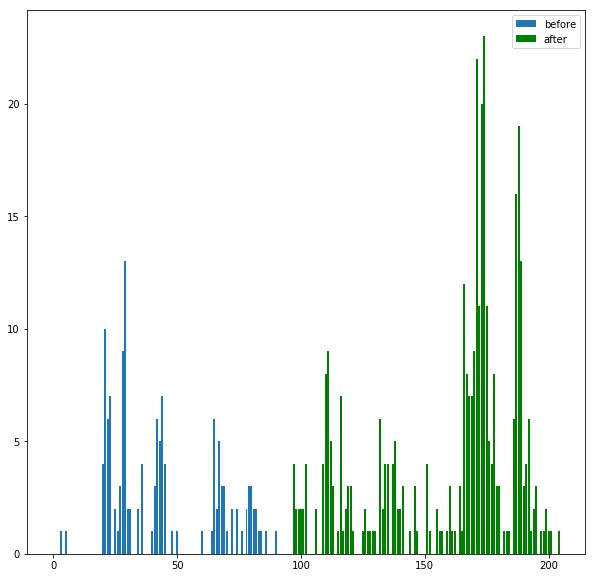

In [26]:
#Everything snow related everything_per_snow_cm
#last_two_winters["Everything snow related"].plot(kind="bar")

plt.bar(last_two_winters.index[:winter_splitter],last_two_winters["Everything snow related"].iloc[:winter_splitter],label="before")
plt.bar(last_two_winters.index[winter_splitter:],last_two_winters["Everything snow related"].iloc[winter_splitter:],color="green",label="after")
plt.legend()

Now just by eyeballing it here we can clearly see that the latest winter has gotten more complaints. Still for the sake of the analysis we'll go through with it. These tools will be of use to you when the data is not so clear. 


# The game plan

When trying to replicate the complaints data points, I must first wonder how this data is generated in the first place. 

When someone calls in to complain, does that cause other people to complain? No.

Can the number of complaints PER DAY keep growing? No, while it may spike here and there, ultimately I'm expecting it to always revert to a mean. 

I founds that there is one distribution that's very well suited for this type of problem. It is called the Poisson distribution.

# Poisson distribution properties:

    It's increments are independent --> One person complaining won't cause other people to complain. 

    It's increments are stationary --> The number of people complaining won't grow. Will always revert to a mean.

    The expected number of complaints over N periods = N*lambda

Lambda indicates expected number of complaints per day.

The poisson distribution answers the question, given the EXPECTED number of events per day what are the odds that I get exactly X number of events in a given period. View below for an example.


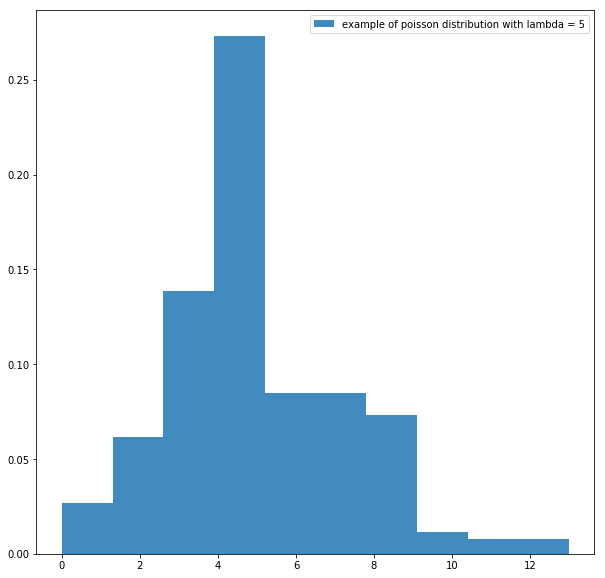

In [27]:

lambda_=5
some_poisson_data=stats.poisson.rvs(lambda_,size=200)
x = np.linspace(0, 1, 200)
plt.hist(some_poisson_data, histtype='stepfilled', bins=10, alpha=0.85,label="example of poisson distribution with lambda = %i"%lambda_,normed=True)
plt.legend()


# Finding Lambda

Now how do I find lambda for my poisson model? 

Well this may sound crazy but I will try to figure out lambda by sampling it from ANOTHER distribution. 

So what distribution could be best describe lambda? 

Well lambda is always positive and one distribution that has a special relationship with the poisson distribution is the exponential distribution. 

While poisson gives us the probability of X events per period, the exponential one gives us the probability of 1 event occuring within the next X periods. 

It's parameter is actually 1/lambda!

Now finally, let's see the actual implementation.


100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:04<00:00, 3275.07it/s]


TypeError: 'int' object is not subscriptable

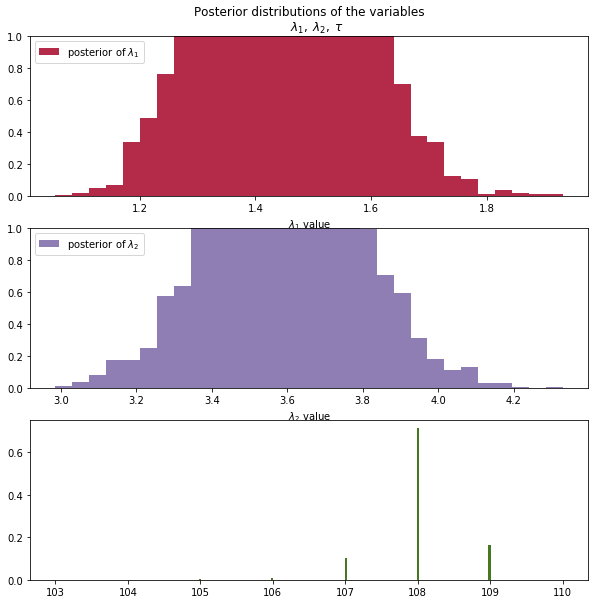

In [32]:
#average number of comments
chosen_variable="Everything snow related"

average_lamba=last_two_winters[chosen_variable].mean() 
number_of_datapoints=last_two_winters.shape[0]

import pymc3 as pm


with pm.Model() as model:
    
    alpha=1/average_lamba
    
    lambda1=pm.Exponential("lambda1",alpha)
    lambda2=pm.Exponential("lambda2",alpha)
    
    tau=pm.DiscreteUniform("tau",lower=0,upper=number_of_datapoints-1)
    
    idx = np.arange(number_of_datapoints) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda1, lambda2)

    #the last part of your model must always have a link to your data
    observation = pm.Poisson("obs", lambda_, observed=last_two_winters[chosen_variable])
    
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)
    
lambda_1_samples = trace['lambda1']
lambda_2_samples = trace['lambda2']
tau_samples = trace['tau']

#figsize(12.5, 10)
#histogram of the samples:

n_count_data=last_two_winters[chosen_variable].shape[0]
count_data=last_two_winters[chosen_variable]

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[::4]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
#plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

# Some analysis...
In the above case we wanted to check if there was a clear difference between the last two winters. In terms of models this means can we model this as two poisson distributions with clearly different lambdas? 

The answer is a very strong yes. 

In the first grid you'll notice that while the first lambda has a wider range of possibilities, it will always be less than 2. The second lambda on the other hand has a much narrower range of possibilities but around the value of 3.5. So this means on average we can expect 3.5 complaints per day during our last winter as opposed to fewer than 2 per day in the previous winter.

But what really makes it clear is the third graph. While we told the model that there'd be two lambdas we didn't tell it where it should "switch" between one model to another. We let the model figure it out. In this case we can see clearly that there is very little doubt as to what day it is. Let's see what that looks like when plotted against the past few winters.


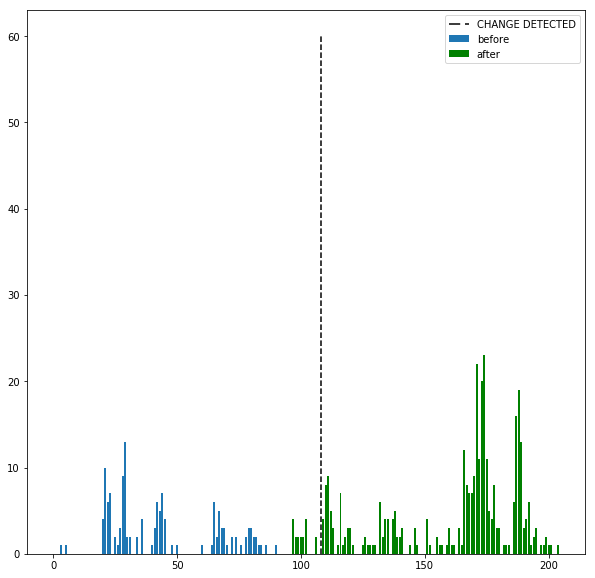

In [29]:


counts = np.bincount(tau_samples)
switch_day=np.argmax(counts)


plt.bar(last_two_winters.index[:winter_splitter],last_two_winters[chosen_variable].iloc[:winter_splitter],label="before")
plt.vlines(switch_day, 0, 60, linestyle="--",label="CHANGE DETECTED")
plt.bar(last_two_winters.index[winter_splitter:],last_two_winters[chosen_variable].iloc[winter_splitter:],color="green",label="after")
plt.legend()




So it's not spot on, but still pretty good right? With this we can objectively say that there was a real difference.

# Would be it be different for the amount of snow taken into consideration?


100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:04<00:00, 3142.06it/s]


TypeError: 'int' object is not subscriptable

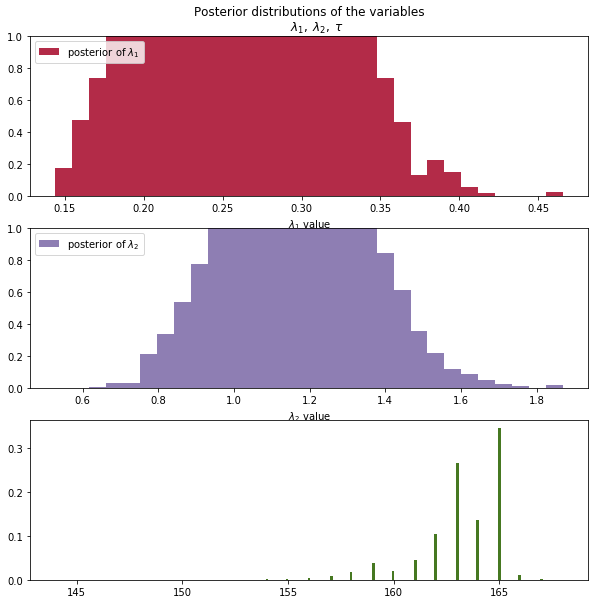

In [33]:
#average number of comments

chosen_variable="everything_per_snow_cm"

average_lamba=last_two_winters[chosen_variable].mean() 
number_of_datapoints=last_two_winters.shape[0]

import pymc3 as pm
import scipy.stats as stats

with pm.Model() as model:
    
    alpha=1/average_lamba
    
    lambda1=pm.Exponential("lambda1",alpha)
    lambda2=pm.Exponential("lambda2",alpha)
    
    tau=pm.DiscreteUniform("tau",lower=0,upper=number_of_datapoints-1)
    
    idx = np.arange(number_of_datapoints) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda1, lambda2)

    #the last part of your model must always have a link to your data
    observation = pm.Poisson("obs", lambda_, observed=last_two_winters[chosen_variable])
    
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)
    
lambda_1_samples = trace['lambda1']
lambda_2_samples = trace['lambda2']
tau_samples = trace['tau']



#figsize(12.5, 10)
#histogram of the samples:

n_count_data=last_two_winters[chosen_variable].shape[0]
count_data=last_two_winters[chosen_variable]

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[::4]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");


Looking at the third table above we can see that once we take the snow into account, it's no longer as clear cut as before. 

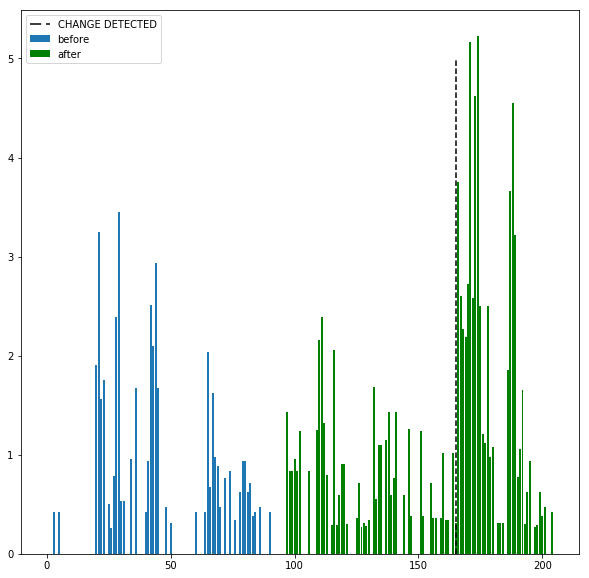

In [31]:

counts = np.bincount(tau_samples)
switch_day=np.argmax(counts)


plt.bar(last_two_winters.index[:winter_splitter],last_two_winters[chosen_variable].iloc[:winter_splitter],label="before")
plt.vlines(switch_day, 0, 5, linestyle="--",label="CHANGE DETECTED")
plt.bar(last_two_winters.index[winter_splitter:],last_two_winters[chosen_variable].iloc[winter_splitter:],color="green",label="after")
plt.legend()




# Some analysis...

While it still detects that if there were a change it would definitely be in the second winter (as none of the "switch dates" refer to the first winter's timespan) it's less clear as to when exactly that would be. All of the likely switch dates are actually halfway across the second winter's term. This means that if the model had to make a guess, the snow plowing company's performance for last winter's first half was probably no different than that of the previous winter..

That's it for this post, hope it was informative!